In [1]:
# load all the modules we use below
from six.moves import cPickle
import os

import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar100
from keras.engine.training import Model
from keras.layers import Add, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, Input
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
#Setup training and test samples

#input image dimensions (32x32x3)
HEIGHT, WIDTH, DEPTH = 32, 32, 3

# CIFAR-100 consists of 100 fine classes, and 20 coarse classes.
N_CLASSES = 100


def load_dataset():
    # load the CIFAR-100 dataset, along with the fine class labels.
    (x_train, y_train), (x_test, y_test) = cifar100.load_data('fine')

    # transform the inputs to range [-1, 1].
    x_train = x_train.astype('float32')
    x_train = (x_train - 127.5) / 127.5
    x_test = x_test.astype('float32')
    x_test = (x_test - 127.5) / 127.5

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, N_CLASSES)
    y_test = keras.utils.to_categorical(y_test, N_CLASSES)

    return (x_train, y_train), (x_test, y_test)
  

(x_train, y_train), (x_test, y_test) = load_dataset()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

169009152/169001437 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 100) (10000, 32, 32, 3) (10000, 100)


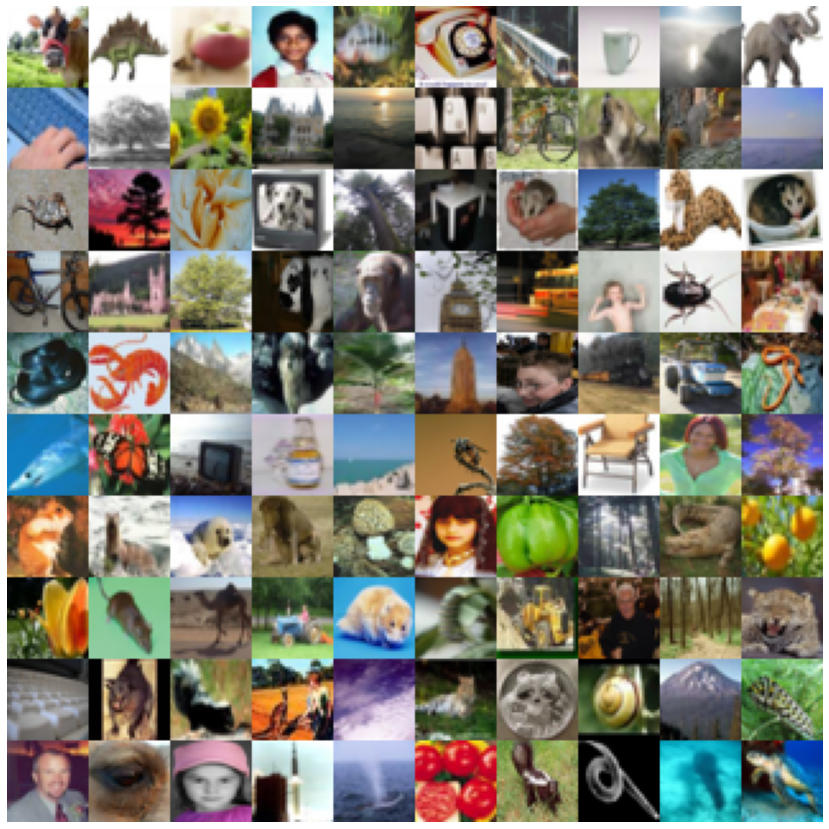

In [3]:
#Show images of cifar100

def plot_images(images, n_images):
    _, h, w, d = images.shape
    # create an array that will store the images to plot.
    canvas = np.empty((h * n_images, w * n_images, d), dtype='uint8')

    for i in range(n_images):
        img_column = images[i * n_images:(i + 1) * n_images]
        for j in range(n_images):
            if j >= img_column.shape[0]:
                break

            # transform images to the range [0, 255]
            img = img_column[j]
            img = ((img * 127.5) + 127.5).clip(0, 255).astype('uint8')            
            canvas[i * h:(i + 1) * h, j * w:(j + 1) * w] = img

    plt.figure(figsize=(1.5 * n_images, 1.5 * n_images))
    plt.axis('off')
    cmap = 'gray' if d == 1 else None
    plt.imshow(canvas.squeeze(), origin="upper", cmap=cmap)
    plt.show()


plot_images(x_train, 10)

In [4]:
#model construction

def build_classifier_model():
    n_conv_blocks = 4  # number of convolution blocks to have in our model.
    n_filters = 32  # number of filters to use in the first convolution block.
    l2_reg = regularizers.l2(2e-4)  # weight to use for L2 weight decay. 
    activation = 'elu'  # the activation function to use after each linear operation.

    if K.image_data_format() == 'channels_first':
        input_shape = (3, HEIGHT, WIDTH)
    else:
        input_shape = (HEIGHT, WIDTH, 3)

    x = input_1 = Input(shape=input_shape)
    
    # each convolution block consists of two sub-blocks of Conv->Batch-Normalization->Activation,
    # followed by a Max-Pooling and a Dropout layer.
    for i in range(n_conv_blocks):
        x = Conv2D(filters=n_filters, kernel_size=(6, 3), padding='same', kernel_regularizer=l2_reg)(x)
        x = BatchNormalization()(x)
        x = Activation(activation=activation)(x)
        
        x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2_reg)(x)
        x = BatchNormalization()(x)        
        x = Activation(activation=activation)(x)
        
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(rate=0.25)(x)
        
        n_filters *= 2

    # finally, we flatten the output of the last convolution block, and add two Fully-Connected layers.
    x = Flatten()(x)
    x = Dense(units=512, kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = Activation(activation=activation)(x)

    x = Dropout(rate=0.5)(x)
    x = Dense(units=N_CLASSES, kernel_regularizer=l2_reg)(x)
    output = Activation(activation='softmax')(x)

    return Model(inputs=[input_1], outputs=[output])


model = build_classifier_model()
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        1760      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0   

In [5]:
#model training
#The learning rate is vaired with the number of epochs

def train_classifier(model_output_path=None, batch_size=128, epochs=100, initial_lr=2e-3):    
    
    def lr_scheduler(epoch):
        if epoch < 20:
            return initial_lr
        elif epoch < 40:
            return initial_lr / 2
        elif epoch < 50:
            return initial_lr / 4
        elif epoch < 60:
            return initial_lr / 8
        elif epoch < 70:
            return initial_lr / 16
        elif epoch < 80:
            return initial_lr / 32
        elif epoch < 90:
            return initial_lr / 64
        else:
            return initial_lr / 128

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(initial_lr),
        metrics=['accuracy']
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(x_test, y_test),
        callbacks=[LearningRateScheduler(lr_scheduler)]
    )

    if model_output_path is not None:
        print('saving trained model to:', model_output_path)
        model.save(model_output_path)
        
    return history


history = train_classifier()
model.save_weights('CNN_Cifar100.hdf5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 27s - loss: 4.4002 - accuracy: 0.1021 - val_loss: 4.0276 - val_accuracy: 0.1453
Epoch 2/100
 - 17s - loss: 3.6149 - accuracy: 0.2068 - val_loss: 3.2688 - val_accuracy: 0.2699
Epoch 3/100
 - 17s - loss: 3.2852 - accuracy: 0.2708 - val_loss: 3.1114 - val_accuracy: 0.3128
Epoch 4/100
 - 17s - loss: 3.1045 - accuracy: 0.3184 - val_loss: 3.0610 - val_accuracy: 0.3337
Epoch 5/100
 - 17s - loss: 2.9968 - accuracy: 0.3518 - val_loss: 2.9396 - val_accuracy: 0.3681
Epoch 6/100
 - 17s - loss: 2.9046 - accuracy: 0.3806 - val_loss: 2.7709 - val_accuracy: 0.4123
Epoch 7/100
 - 17s - loss: 2.8575 - accuracy: 0.4003 - val_loss: 2.7762 - val_accuracy: 0.4250
Epoch 8/100
 - 17s - loss: 2.8020 - accuracy: 0.4213 - val_loss: 2.7358 - val_accuracy: 0.4531
Epoch 9/100
 - 17s - loss: 2.7730 - accuracy: 0.4338 - val_loss: 2.6605 - val_accuracy: 0.4711
Epoch 10/100
 - 17s - loss: 2.7388 - accuracy: 0.4490 - val_loss: 2.6210 - val_accuracy: 0.4750

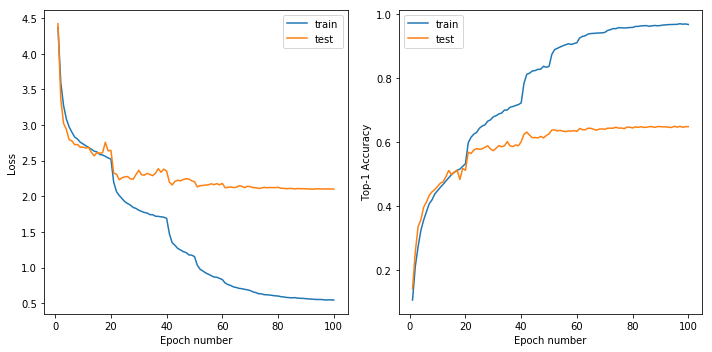

In [ ]:
def plot_training_history(history):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].plot(np.arange(1, epochs + 1), loss, label='train')
    axs[0].plot(np.arange(1, epochs + 1), val_loss, label='test')
    axs[0].set_xlabel('Epoch number')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc="best")

    acc, val_acc = history.history['acc'], history.history['val_acc']
    axs[1].plot(np.arange(1, epochs + 1), acc, label='train')
    axs[1].plot(np.arange(1, epochs + 1), val_acc, label='test')
    axs[1].set_xlabel('Epoch number')
    axs[1].set_ylabel('Top-1 Accuracy')
    axs[1].legend(loc="best")
    
    plt.tight_layout()
    plt.show()
    
    
plot_training_history(history)

In [ ]:
print('Train-set performance --> loss: {:.4f}, accuracy: {:.4f}'.format(*model.evaluate(x_train, y_train, verbose=0)))
print('Test-set performance --> loss: {:.4f}, accuracy: {:.4f}'.format(*model.evaluate(x_test, y_test, verbose=0)))

Train-set performance --> loss: 0.4431, accuracy: 0.9996
Test-set performance --> loss: 2.1012, accuracy: 0.6491


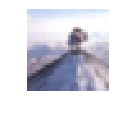

road: 48.8782%, train: 46.1362%, sea: 2.1944%, man: 0.8892%, bridge: 0.4818%


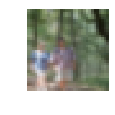

forest: 52.8096%, rabbit: 42.0335%, house: 3.1395%, rocket: 0.4369%, can: 0.2414%


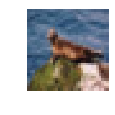

dolphin: 45.5910%, otter: 31.6157%, beaver: 16.4769%, seal: 2.4808%, shark: 0.9962%


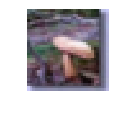

mushroom: 99.5944%, elephant: 0.2502%, forest: 0.0482%, table: 0.0339%, house: 0.0243%


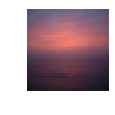

sea: 95.4268%, cloud: 4.5009%, plain: 0.0722%, mountain: 0.0001%, apple: 0.0000%


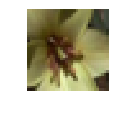

spider: 91.2722%, bee: 5.8622%, beetle: 2.5972%, cockroach: 0.2599%, orchid: 0.0029%


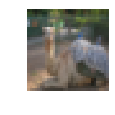

squirrel: 83.2659%, tiger: 4.1688%, beaver: 3.8301%, rabbit: 3.7527%, crocodile: 1.8551%


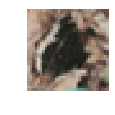

beetle: 54.9052%, chimpanzee: 23.2063%, bee: 5.3763%, bear: 5.3274%, cockroach: 4.5620%


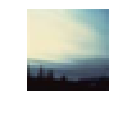

sea: 98.3364%, cloud: 1.1298%, plain: 0.5323%, forest: 0.0009%, mountain: 0.0004%


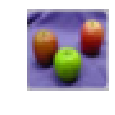

pear: 44.8485%, apple: 25.8211%, orange: 22.8806%, sweet_pepper: 6.4497%, bowl: 0.0001%


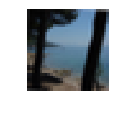

bridge: 57.0415%, skyscraper: 21.5865%, television: 15.9410%, sea: 4.0282%, pine_tree: 0.4265%


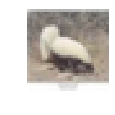

skunk: 99.7380%, seal: 0.1882%, trout: 0.0549%, dolphin: 0.0072%, whale: 0.0058%


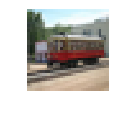

streetcar: 99.9326%, train: 0.0575%, bus: 0.0099%, tractor: 0.0000%, house: 0.0000%


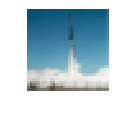

rocket: 100.0000%, sea: 0.0000%, palm_tree: 0.0000%, skyscraper: 0.0000%, cloud: 0.0000%


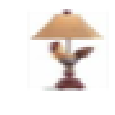

lamp: 100.0000%, woman: 0.0000%, man: 0.0000%, orchid: 0.0000%, mushroom: 0.0000%


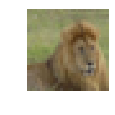

lion: 99.9997%, tiger: 0.0002%, kangaroo: 0.0001%, chimpanzee: 0.0000%, bear: 0.0000%


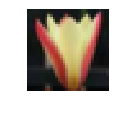

tulip: 99.9993%, sweet_pepper: 0.0007%, poppy: 0.0000%, aquarium_fish: 0.0000%, cup: 0.0000%


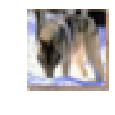

wolf: 72.0529%, hamster: 27.0302%, squirrel: 0.3394%, tiger: 0.2161%, mouse: 0.2015%


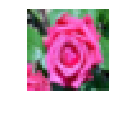

rose: 100.0000%, tulip: 0.0000%, orchid: 0.0000%, maple_tree: 0.0000%, clock: 0.0000%


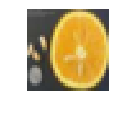

orange: 99.9825%, pear: 0.0060%, rose: 0.0057%, poppy: 0.0033%, tulip: 0.0019%


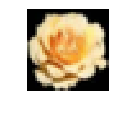

rose: 99.9988%, poppy: 0.0009%, tulip: 0.0002%, maple_tree: 0.0000%, hamster: 0.0000%


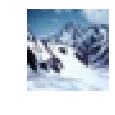

mountain: 41.2842%, keyboard: 35.2218%, whale: 9.6891%, shark: 5.8221%, dolphin: 3.4976%


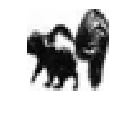

skunk: 92.8277%, cattle: 2.5431%, lawn_mower: 1.1495%, elephant: 0.8659%, bowl: 0.3631%


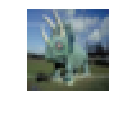

maple_tree: 33.6201%, willow_tree: 24.0038%, pine_tree: 16.5686%, palm_tree: 6.7659%, castle: 6.4016%


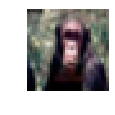

chimpanzee: 99.9508%, man: 0.0407%, girl: 0.0043%, woman: 0.0040%, boy: 0.0003%


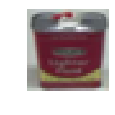

can: 99.9984%, clock: 0.0008%, wardrobe: 0.0005%, bowl: 0.0001%, bottle: 0.0001%


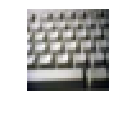

keyboard: 100.0000%, orange: 0.0000%, couch: 0.0000%, streetcar: 0.0000%, bus: 0.0000%


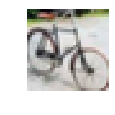

bicycle: 100.0000%, motorcycle: 0.0000%, spider: 0.0000%, lizard: 0.0000%, beetle: 0.0000%


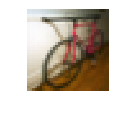

bicycle: 99.0417%, motorcycle: 0.1878%, spider: 0.1742%, rabbit: 0.1403%, baby: 0.1358%


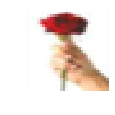

lobster: 86.9263%, boy: 3.1345%, pine_tree: 3.0202%, cup: 1.3370%, bee: 1.2485%


In [ ]:
def load_label_names():
    dirname = 'cifar-100-python'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
    path = keras.utils.get_file(dirname, origin=origin, untar=True)

    fpath = os.path.join(path, 'meta')
    label_names = cPickle.load((open(fpath, 'rb')), encoding='bytes')
    label_names = [name.decode('ascii') for name in label_names[b'fine_label_names']]
    label_names = np.array(label_names)
    return label_names


label_names = load_label_names()


def get_prediction(x, top_n=5):
    predictions = model.predict(x)[0]
    predictions *= 100
    order = np.argsort(predictions)[::-1]
    sorted_predictions = list(zip(label_names[order], predictions[order]))
    print(', '.join(['{}: {:.4f}%'.format(label, confidence) for label, confidence in sorted_predictions[:top_n]]))


fignum=30    
for i in range(fignum):
  img = x_test[i, np.newaxis]
  plot_images(img, 1)
  get_prediction(img)

conv2d_9 (6, 3, 3, 32)


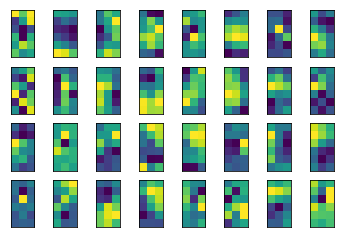

conv2d_10 (3, 3, 32, 32)


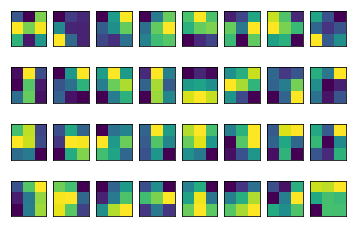

conv2d_11 (6, 3, 32, 64)


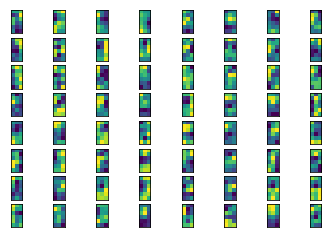

conv2d_12 (3, 3, 64, 64)


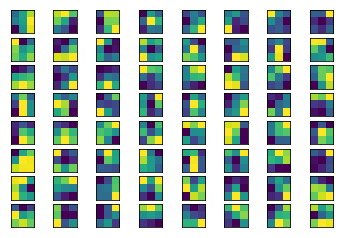

conv2d_13 (6, 3, 64, 128)


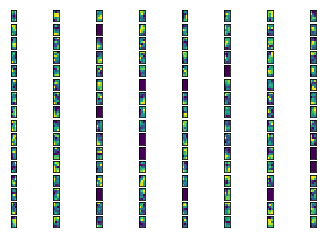

conv2d_14 (3, 3, 128, 128)


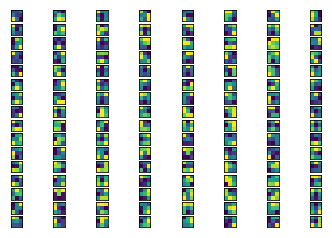

conv2d_15 (6, 3, 128, 256)


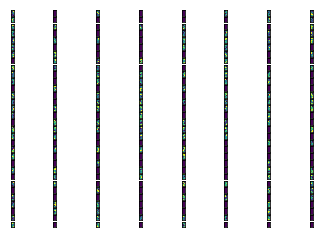

conv2d_16 (3, 3, 256, 256)


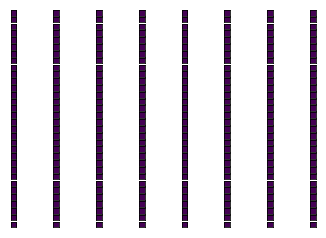

In [ ]:
#Show filters of conv layers
#https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
from matplotlib import pyplot

# summarize filter shapes
for layer in model.layers:
  if 'conv' in layer.name:
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)
    #normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters = filters.shape[3]
    #print(n_filters)
    column= round(n_filters/8)
    row=round(n_filters/column)
    #print(row)
    for i in range(row):
      for j in range(column):
      # get the filter
        f = filters[:, :, :, i*column+j-1]
        # specify subplot and turn of axi
        ax = pyplot.subplot(column, row, i*column+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(f[:, :, 0])
      # show the figure
    pyplot.show()